In [1]:
import numpy as np
from scipy.stats import chi2_contingency, chi2
from pyprojroot import here
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Chi-squared testing
## Independence and Goodness-of-fit

This notebook demonstrates the two variations of the Chi-squared test:
1. Chi-squared test of independence
    - Whether two categorical variables are independent
3. Chi-squared goodness-of-fit test
    - Whether the distribution of a single categorical variable matches an expected distribution


## Introduction

This section provides a general introduction to Chi-squared testing. For any specifics of the Chi-squared varients, see the individual sections [**Test of Independence**](#Test-of-Independence) or [**Goodness-of-fit Test**](#Goodness-of-fit-Test).

## Requirements

This notebook uses the `Heart Failure Prediction Dataset` which can be found [here](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) (08/06/2025). The dataset should be downloaded and placed into the `data` directory at the project root.

In [2]:
df = pd.read_csv(here("data/heart.csv"))
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Test of Independence

For this example, we will test if the *biological sex (M/F)* of an individual affects heart disease. We can formulate the above as such:

**Hypotheses**

$ Let\ X\ = biological\ sex,\ Y = heart\ failure $ 
- $ H_0: P(Y | X) = P(Y) $ (Y depends on X)
- $ H_a: P(Y | X) \neq P(Y)$ (Y is independent of X)

We shall use an alpha value of 0.05 to determine significance.

$$ alpha = 0.05 $$

To ease demonstration let's filter the original data for only the columns needed for this example.

In [3]:
df_independence = df[["Sex", "HeartDisease"]]
df_independence.head()

,Sex,HeartDisease
0,M,0
1,F,1
2,M,0
3,F,1
4,M,0


The chi-squared test requires a contingency table. This can easily be done using `pandas'` `crosstab()` function.

In [4]:
contingency = pd.crosstab(df["Sex"], df["HeartDisease"])
contingency

HeartDisease,0,1
Sex,,
F,143,50
M,267,458


Perform the test using `scipy's` `chi2_contingency` function.

In [5]:
chi2_stat, p_chi, df, expected = chi2_contingency(contingency)

print(f"chi2 statistic: {chi2_stat:.4f}")
print(f"p-value: {p_chi:.4f}")

chi2 statistic: 84.1451
p-value: 0.0000


Observations:
- A Chi-squared test statistic of 84.15 indicates that the observed differences between heart failure rates in males and females are large relative to what would be expected if the two variables were independent. This suggests a potential association between biological sex and heart failure outcome.
- A p-value < 0.001 is much smaller than our alpha of 0.05

In conclusion, based off of the above results, we reject the null hypothesis of independence and conclude that there is strong statistical evidence of an association between biological sex and heart failure.

We can plot our statistic visually against the chi-squared distribution.

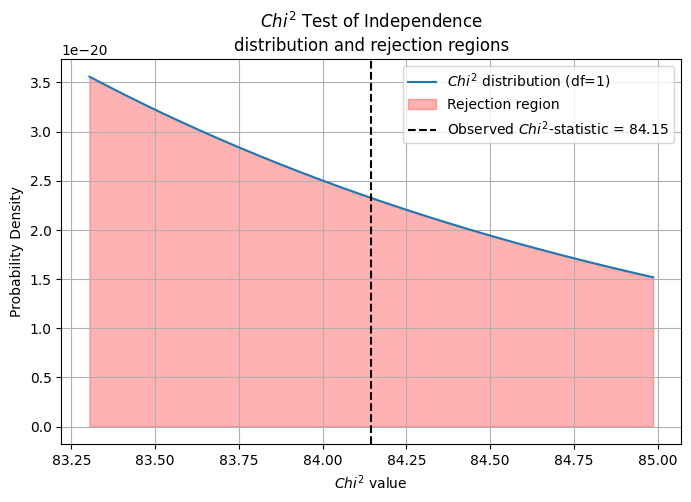

In [20]:
# Parameters
alpha = 0.05

# Define x range ±1% around statistic
# chi2 distribution is non-negative
x_min = max(0, chi2_stat * 0.99)
x_max = chi2_stat * 1.01
x = np.linspace(x_min, x_max, 500)
y = chi2.pdf(x, df)

plt.figure(figsize=(8, 5))
plt.plot(x, y, label=f'$Chi^2$ distribution (df={df:.0f})')

# shade rejection region
plt.fill_between(x, 0, y, color='red', alpha=0.3, label='Rejection region')

# mark statistic
plt.axvline(chi2_stat, color='black', linestyle='--', label=f'Observed $Chi^2$-statistic = {chi2_stat:.2f}')

plt.title('$Chi^2$ Test of Independence\ndistribution and rejection regions')
plt.xlabel('$Chi^2$ value')
plt.ylabel('Probability Density')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

We can examine what a contingency table *would* look like if there was *no* observed association between biological sex and heart failure. 

In [7]:
expected_contingency = pd.DataFrame(expected, index=contingency.index, columns=contingency.columns)
expected_contingency

HeartDisease,0,1
Sex,,
F,86.198257,106.801743
M,323.801743,401.198257


From this, let's calculate the standardised residuals (by expected) to see where the largest deviations occur.

In [8]:
residuals = (contingency - expected_contingency) / expected_contingency.pow(0.5) 
residuals

HeartDisease,0,1
Sex,,
F,6.118042,-5.496326
M,-3.156618,2.835843


<Axes: xlabel='HeartDisease', ylabel='Sex'>

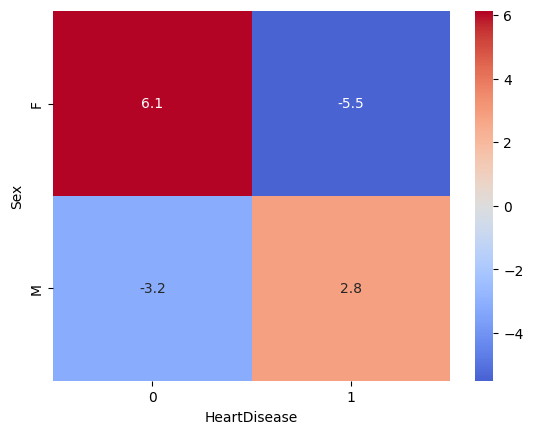

In [9]:
sns.heatmap(residuals, annot=True, cmap="coolwarm", center=0)

Standardised residuals observations:
- Females: Far more without heart disease (+6.1) than expected, and far less with heart disease than expected (-5.5), assuming independence
- Males: Fewer men without heart disease than expected (-3.2), and more men with heart disease than expected (2.8), again, assuming independence

It is important to note the contrasting pattern across the diagonals of the residuals matrix:
- The top-left -> bottom-right diagonal (females without heart disease and males with heart disease) shows more occurrences than expected under the assumption of independence.
- The bottom-left -> top-right diagonal (females with heart disease and males without heart disease) shows fewer occurrences than expected.

This diagonal pattern supports the conclusion that males are more likely to have heart disease than females in this dataset, indicating a significant association between biological sex and heart disease occurrence in this data.

## Goodness-of-fit Test

For this example, we will examine if the dataset is balances in terms of *biological sex (M/F)*